# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib inline
import lightkurve as lk
import gatspy
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import hist as ahist
import scipy.stats as st
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import ConstantKernel as C ,ExpSineSquared as ESS
from sklearn.gaussian_process import GaussianProcessRegressor

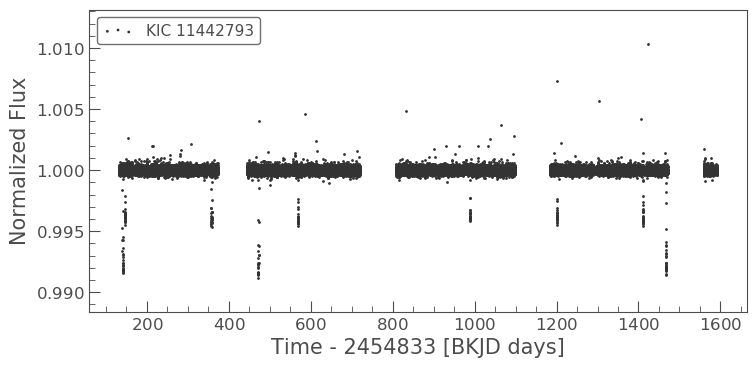

In [2]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

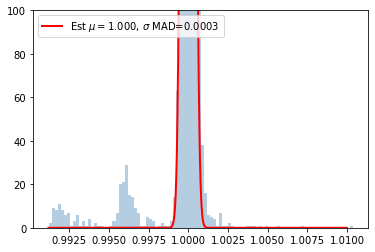

In [3]:
#outlier removal
ahist(clc.flux, bins=100,color='steelblue',alpha=0.4);
median = np.median(clc.flux)
#sig_robust = st.iqr(clc.flux)/1.349
sig_robust = 1.4826*st.median_absolute_deviation(clc.flux)
xval = np.arange(np.min(clc.flux), 1.01, 1e-5)
estpdf  = st.norm.pdf(xval, loc=median, scale=sig_robust)
plt.plot(xval, estpdf, color='r', lw=2, label=fr'Est $\mu=${median:.3f}, $\sigma$ MAD={sig_robust:.4f}')
plt.ylim(0,100)
plt.legend(loc='upper left')

In [4]:
median + 3*sig_robust

1.000788925394507

In [5]:
inx = np.where(clc.flux < 1.0008)
#time = clc.time[inx][::50]
#flux = clc.flux[inx][::50]
time = clc.time[inx]
flux = clc.flux[inx]

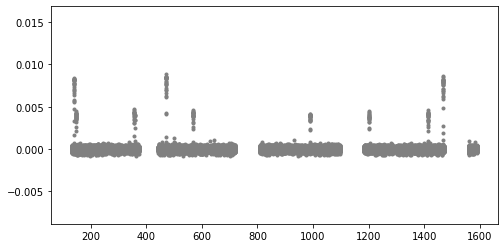

In [50]:
flux = -(flux-1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.scatter(time,flux,marker='.',color='grey')

In [190]:
model_gatspy = gatspy.periodic.LombScargle(Nterms=5)
model_gatspy.fit(time,flux)

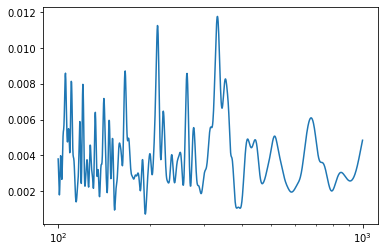

In [191]:
periods = np.logspace(2,3,num=1000, endpoint=False)
power = model_gatspy.periodogram(periods)
plt.plot(periods, power)
plt.xscale('log')

In [192]:
model_gatspy.optimizer.period_range = (100,500)
period = model_gatspy.best_period
periods = model_gatspy.find_best_periods()

Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 5 steps per peak; omega_step = 0.000861
 - User-specified period range:  99 to 5e+02
 - Computing periods at 60 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 5 steps per peak; omega_step = 0.000861
 - User-specified period range:  99 to 5e+02
 - Computing periods at 60 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 2000 steps


In [193]:
periods

array([333.2944614 , 211.98167909, 165.79494218, 105.64542844,
       264.64097607])

In [194]:
print("The period of planet 1:", periods[0])
print("The period of planet 2:", periods[1])

The period of planet 1: 333.294461401304
The period of planet 2: 211.98167909257143


Text(0.5, 1.0, 'Fit with 2 planets')

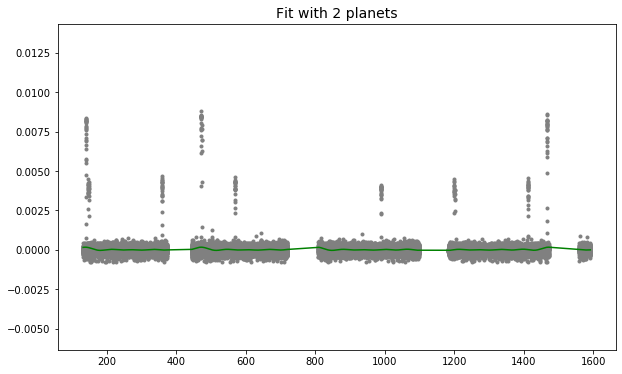

In [196]:
#tfit = np.linspace(0, 1600, 30000)
yfit = model_gatspy.predict(time)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
#plt.scatter(time%period,flux,marker='.',color='grey')
plt.scatter(time,flux,marker='.',color='grey')
plt.plot(time,yfit,color='g')
plt.title('Fit with 2 planets',fontsize=14)

#period1 = period

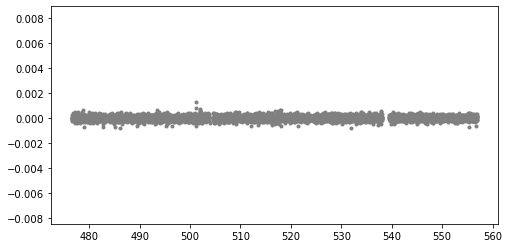

In [203]:
#Looking at data with lower periodicty in a chunck of the total data

time2,flux2 = time[12149+200:12149+4000],flux[12149+200:12149+4000]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.scatter(time[12149+200:12149+4000],flux[12149+200:12149+4000],marker='.',color='grey')

Periodogram on the small chunck of data

In [221]:
model_gatspy = gatspy.periodic.LombScargle(Nterms=1)
model_gatspy.fit(time2,flux2)

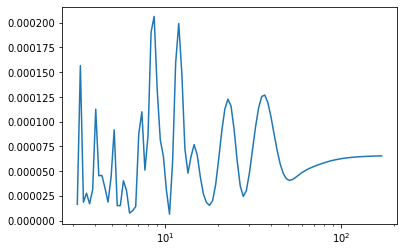

In [222]:
periods = np.logspace(0.5,2.25,num=100, endpoint=False)
power = model_gatspy.periodogram(periods)
plt.plot(periods, power)
plt.xscale('log')

In [224]:
model_gatspy.optimizer.period_range = (5,20)
period = model_gatspy.find_best_periods()

Finding optimal frequency:
 - Estimated peak width = 0.0781
 - Using 5 steps per peak; omega_step = 0.0156
 - User-specified period range:  5 to 20
 - Computing periods at 62 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 2000 steps


In [225]:
period

array([ 8.52783184, 11.90944119,  7.27592627,  5.06847536, 21.04588976])

In [226]:
print("The period of planet 3:", period[0])

The period of planet 3: 8.527831843889569


# Gaussian Process

We use two planet periods for the kernel

In [ ]:
X = np.atleast_2d(time[::20]).T
Y = np.atleast_2d(flux[::20]).T
kernel = C()*ESS(length_scale=0.125,length_scale_bounds=(0.1,10),periodicity=333.294461401304, periodicity_bounds=(328,338))+C()*ESS(length_scale=0.125,length_scale_bounds=(0.1,10),periodicity=211.98167909, periodicity_bounds=(208,214))
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=9)
gp.fit(X,Y)
x_pred = np.atleast_2d(np.linspace(np.min(time[::20]),np.max(time[::20]),5*len(time[::20]))).T
y_pred, sigma_pred = gp.predict(x_pred, return_std=True)

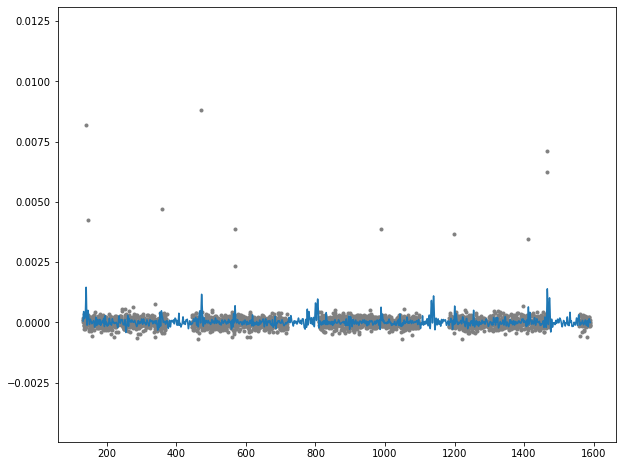

In [186]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
ax.scatter(time[::20],flux[::20],marker='.',color='grey')
ax.plot(x_pred.flatten(),y_pred.flatten())
# ax.fill_between(x_pred.flatten(),y_pred.flatten()-sigma_pred.flatten(),y_pred.flatten()+sigma_pred.flatten()
#                 ,alpha=0.2)

In [187]:
gp.kernel_

1**2 * ExpSineSquared(length_scale=0.125, periodicity=333) + 1**2 * ExpSineSquared(length_scale=0.125, periodicity=212)

Sampling every 100 points is not sufficient cadence